# 市场影响模型

By Dr. Michele Goe

Part of the Quantopian Lecture Series:
* https://www.quantopian.com/lectures
* https://github.com/quantopian/research_public
---

在这一讲中，我们试图澄清交易成本以及它们如何影响算法性能。在这堂课结束时，你应该能够:
1. 根据已发表的市场影响模型研究和我们自己的经验，了解影响交易成本的属性
2. 了解周转率、交易成本和杠杆对战略绩效的影响
3. 熟悉机构定量交易团队如何思考和衡量交易成本。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

## 交易成本简介


交易成本可分为两类
* 直接(佣金和费用):明确，容易衡量，在机构交易中，相对“小”
* 间接成本(市场影响和传播成本):**本次讲座的目的**

滑动是指价格在交易完全执行之前“下滑”，导致填充价格与订单时的价格不同。
我们的研究显示，对股价下滑影响最大的交易有以下几点:
1. **波动**
2. **流动性**
3. **相对订单大小**
4. **买卖价差**

## 交易成本对投资组合绩效的影响

让我们考虑一个假设的中频统计套利\*组合:

Algo Attribute| Qty 
---|----
Holding Period (weeks) |1 
Leverage | 2 
AUM (million) | 100 
Trading Days per year | 252
Fraction of AUM traded per day | 0.4


这意味着我们每年大约有50次进出一个新的投资组合。在2倍的杠杆作用下，在1亿的资产中，我们每年交易200亿美元。

**问:对于这种水平的流失率，执行成本增加1个基点对基金回报率的影响是什么?**

这意味着对于每一个基点($0.01\%$)的交易成本，我们将损失$2\%$ 算法性能。

\*需要说明的是，一个中间频率策略大致指的是在$0.05$到$0.67$之间的日换手率。这表示一天到一周的等待时间。统计套利是指根据一个统计模型，利用计算算法同时买卖股票。

In [2]:
def perf_impact(leverage, turnover , trading_days, txn_cost_bps):
    p = leverage *  turnover * trading_days * txn_cost_bps/10000.
    return p

In [3]:
print(perf_impact(leverage=2, turnover=0.4, trading_days=252, txn_cost_bps=1)) 

0.02016


## 机构量化交易团队如何评估交易成本?

量化机构交易团队通常采用执行策略，目的是完全完成上级订单，同时最小化执行成本。为了实现这一目标，通常将父订单分解为许多子订单，这些子订单被路由到不同的执行场所，目标是捕获所有可用的流动性并最小化买卖价差。父级执行价格可以表示为所有子订单的量加权平均价格。

**问:我们应该将执行价格与什么基准进行比较?**

*定量平仓交易团队基准:*
* **到达价格** -算法的“决定”价格，定义为算法发出父订单时的中间报价(mid是最佳报价和报价之间的中间点)
* **区间VWAP** -订单有效期内的成交量加权平均价格
* **T+10分钟** -反转基准，价格10分钟后的最后一次填充vs执行价格
* **T+30分钟** -反转基准，价格30分钟后的最后一次填充vs执行价格
* **收盘价** -反转基准，价格在关闭与执行价格
* **开盘价**  -动量基准，开盘价vs执行价
* **前一交易日收盘** -动量基准，前一交易日收盘价格vs执行价格
*其他指标和定义


$$ Metric  = \frac{Side * (Benchmark - Execution\thinspace Price )* 100 * 100}{ Benchmark }$$

*主要观点*
* **执行价格** -所有填充订单或子订单的体积加权平均价格
* **成本vs到货价格** -到货价格与执行价格之间的差异，以基点表示。这个基准的思想是将执行价格与策略的决策价格进行比较。这种成本有时被称为“延误”或“执行不足”。

在订单执行之后，降级指标为我们提供了临时影响的指示。一般来说，我们希望股票价格在我们完成订单后会有所回升，因为我们对买卖不平衡的贡献反映在市场上。动量指标为我们提供了执行前价格漂移方向的指示。通常情况下，强劲的交易势头会影响我们将买卖价差降至最低的能力。

在执行订单时，需要考虑的主要权衡之一是时机风险与市场影响:
* **时间风险** -价格漂移和信息泄漏的风险之间的间隔到达，中间报价和最后一次填补增加。
* **市场影响** -(高度紧急)移动市场的风险，缩短到达、中期报价和最后一次报价之间的间隔。

在这个框架内，执行的中性紧急性发生在市场风险和市场影响的交集处——在这种情况下，每个因素对执行成本的贡献是相同的。

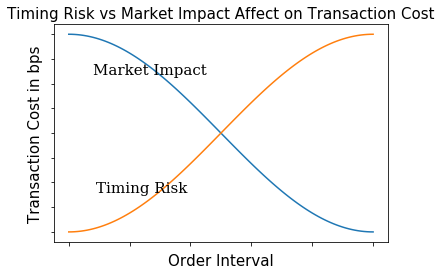

In [4]:
x = np.linspace(0,1,101)
risk = np.cos(x*np.pi)
impact = np.cos(x* np.pi+ np.pi)

fig,ax = plt.subplots(1)
# Make your plot, set your axes labels
ax.plot(x,risk)
ax.plot(x,impact)
ax.set_ylabel('Transaction Cost in bps', fontsize=15)
ax.set_xlabel('Order Interval', fontsize=15)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.grid(False)
ax.text(0.09, -0.6, 'Timing Risk', fontsize=15, fontname="serif")
ax.text(0.08, 0.6, 'Market Impact', fontsize=15, fontname="serif")
plt.title('Timing Risk vs Market Impact Affect on Transaction Cost', fontsize=15)
plt.show()

## **流动性**

流动性可以通过几个方面来观察。在执行管理的背景下，我们可以把它看作是活动，以股票和交易的美元来衡量，以及在市场上执行的交易的频率和规模。“良好”的流动性也是通过市场双方不同数量的市场参与者实现的。

评估流动性:
* 日内成交量曲线
* 当天成交量的百分比
* 平均每日美元交易量的百分比
* 累计日内成交量曲线
* 相对订单大小

一般来说，流动性在接近收盘时是最高的，在开盘时是第二高的。中午的流动性最低。流动性还应考虑相对于您的订单规模和其他证券在同一部门和类别。

Time: 0.31 seconds.


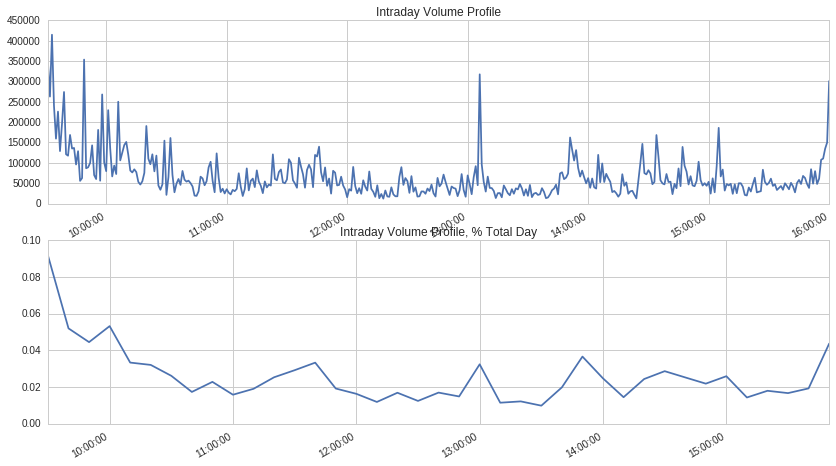

In [5]:
tickers = symbols(['FB']) # Facebook ticker
num_stocks = len(tickers)

# %%timeit -n1 -r1 magic is not allowed in Q
start = time.time()
data = get_pricing(tickers,fields='volume', frequency='minute', start_date='2016-1-1',  end_date='2016-7-1')
end = time.time()
print("Time: %0.2f seconds." % (end - start)) 
data = data.tz_convert('US/Eastern') # Q data comes in as UTC

dat = data[symbols('FB')]
plt.subplot(211)
dat['2016-04-14'].plot(title='Intraday Volume Profile') # intraday volume profile plot 
plt.subplot(212)
(dat['2016-04-14'].resample('10t', closed='right').sum()/\
     dat['2016-04-14'].sum()).plot(); # percent volume plot
plt.title('Intraday Volume Profile, % Total Day');

In [6]:
df = pd.DataFrame(dat) # Facebook minutely volume data

df.columns = ['interval_vlm'] 

df_daysum = df.resample('d').sum() # take sum of each day 
df_daysum.columns = ['day_vlm']
df_daysum['day'] = df_daysum.index.date # add date index as column

df['min_of_day']=(df.index.hour-9)*60 + (df.index.minute-30) # calculate minutes from open
df['time']=df.index.time # add time index as column

conversion = {'interval_vlm':'sum', 'min_of_day':'last', 'time':'last'}
df = df.resample('10t', closed='right').apply(conversion) # apply conversions to columns at 10 min intervals
df['day'] = df.index.date

df = df.merge(df_daysum, how='left', on='day') # merge df and df_daysum dataframes
df['interval_pct'] = df['interval_vlm'] / df['day_vlm'] # calculate percent of days volume for each row
df.head()

,interval_vlm,time,min_of_day,day,day_vlm,interval_pct
0,2553931.0,09:40:00,10.0,2016-01-04,31872469.0,0.080130
1,2246748.0,09:50:00,20.0,2016-01-04,31872469.0,0.070492
2,1518230.0,10:00:00,30.0,2016-01-04,31872469.0,0.047635
3,1599570.0,10:10:00,40.0,2016-01-04,31872469.0,0.050187
4,1909115.0,10:20:00,50.0,2016-01-04,31872469.0,0.059899


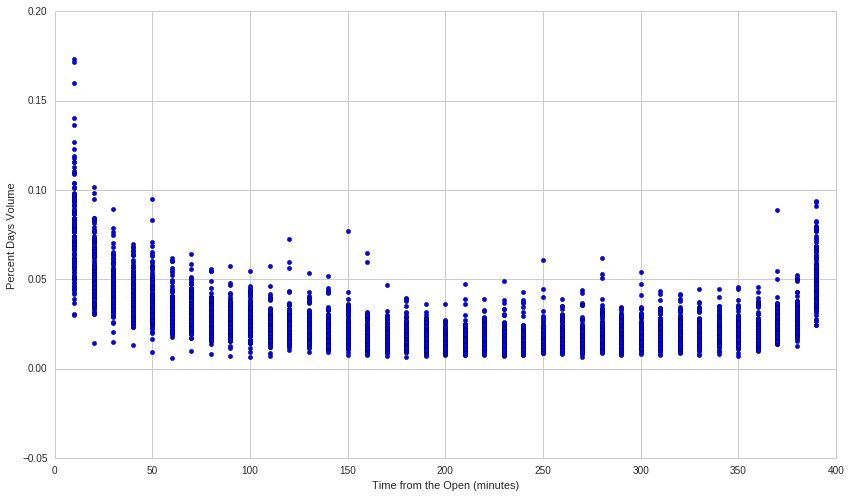

In [7]:
plt.scatter(df.min_of_day, df.interval_pct)
plt.xlim(0,400)
plt.xlabel('Time from the Open (minutes)')
plt.ylabel('Percent Days Volume')

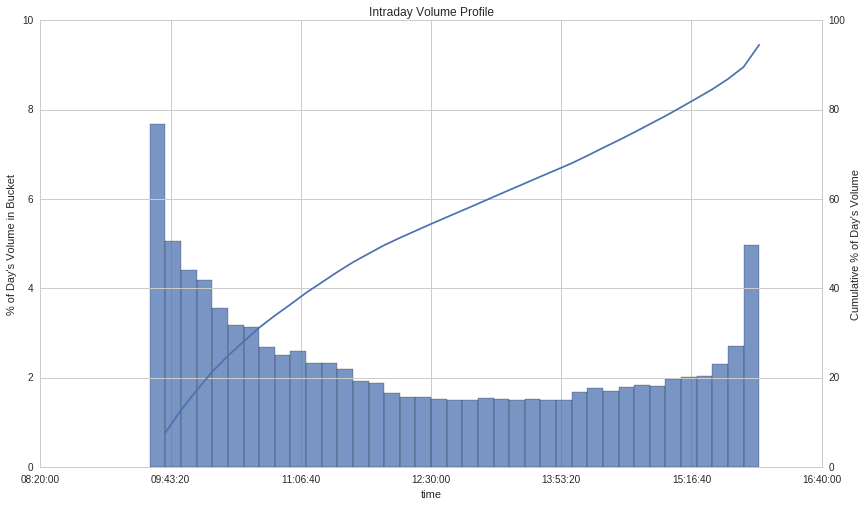

In [8]:
grouped = df.groupby(df.min_of_day)
grouped = df.groupby(df.time) # group by 10 minute interval times
m = grouped.median()  # get median values of groupby
x = m.index
y = m['interval_pct']

fig, ax1 = plt.subplots();
ax1.bar(x, 100*y, -60*10 ,alpha=0.75); # plot percent daily volume grouped by 10 minute interval times
ax1.set_ylim(0,10);
ax2 = ax1.twinx();
ax2.plot(x,(100*y).cumsum()); # plot cummulative distribution of median daily volume
ax2.set_ylim(0,100);
plt.title('Intraday Volume Profile');
ax1.set_ylabel('% of Day\'s Volume in Bucket');
ax2.set_ylabel('Cumulative % of Day\'s Volume');


## 相对订单大小

当我们以指定的参与率增加相对订单大小时，完成订单的时间就会增加。假设我们使用VWAP执行订单,调度策略,将执行订单在预先确定的时间窗口,根据体积分布的预测在时间窗口:在3%的参与率VWAP执行,我们需要一整天贸易如果订单占日均成交量的3%。

如果我们预期我们的算法有较高的相对订单大小，那么我们可能希望在交易时切换到流动性管理执行策略，以确保订单在当天结束前完成。流动性管理执行策略对于执行的迫切性、执行地点的选择以及以完成订单为目标的分散获取都有特定的约束。回到我们的风险曲线，我们预期交易时间越长交易成本越高。因此，订单的ADV百分比越高，交易成本越高。

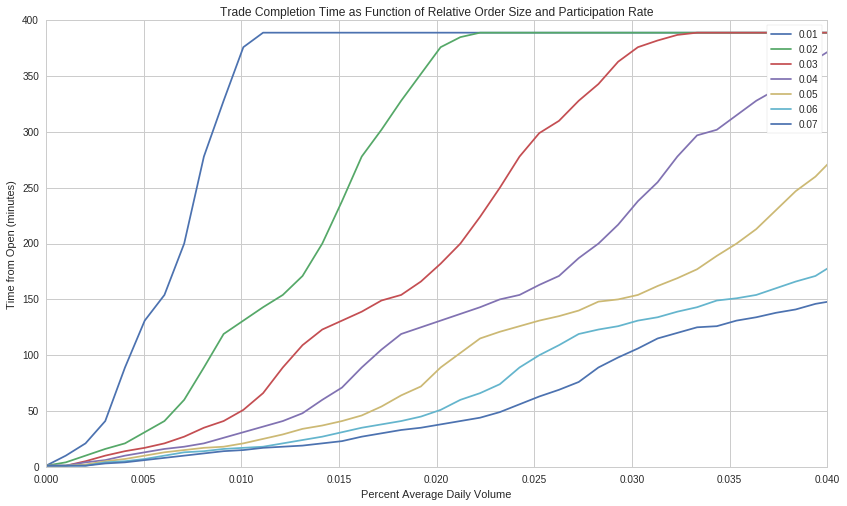

In [9]:

dat = get_pricing(symbols(['FB']), fields='volume', frequency='minute', start_date='2016-1-1', end_date='2018-1-2')
dat = dat.tz_convert('US/Eastern') # Q data comes in as UTC


def relative_order_size(participation_rate, pct_ADV):
    fill_start = dat['2017-10-02'].index[0] # start order at 9:31
    ADV20 = int(dat.resample("1d").sum()[-20:].mean()) # calculate 20 day ADV
    order_size = int(pct_ADV * ADV20)
    #print 'order size:', order_size, 'daily volume:', dat['2016-07-01'].sum()/(1.0*10**6), 'M shares'
    try :
        ftime = dat['2017-10-02'][(order_size * 1.0 / participation_rate)<=dat['2017-10-02'].cumsum().values].index[0]
    except: 
        ftime = dat['2017-10-02'].index[-1] # set fill time to 4p 
    fill_time = max(1,int((ftime - fill_start).total_seconds()/60.0))
    #print 'order fill time' ,fill_time,  'minutes'
    return fill_time

def create_plots(participation_rate, ax):
    df_pr = pd.DataFrame(data=np.linspace(0.0,0.1,100), columns = ['adv'] ) # create dataframe with intervals of ADV
    df_pr['pr'] = participation_rate # add participation rate column

    df_pr['fill_time'] = df_pr.apply(lambda row: relative_order_size(row['pr'],row['adv']), axis = 1) # get fill time

    ax.plot(df_pr['adv'],df_pr['fill_time'], label=participation_rate) # generate plot line with ADV and fill time

fig, ax = plt.subplots() 
for i in [0.01,0.02,0.03,0.04,0.05,0.06,0.07]: # for participation rate values
    create_plots(i,ax) # generate plot line
    
plt.ylabel('Time from Open (minutes)')
plt.xlabel('Percent Average Daily Volume')
plt.title('Trade Completion Time as Function of Relative Order Size and Participation Rate')
plt.xlim(0.,0.04)
ax.legend()



## 波动性

波动性是一种衡量证券收益分散程度的统计指标。以收益率的标准差计算。任何一只股票的波动率通常在开盘时达到顶峰，然后下降，直到中午。波动性越高，收益的不确定性越大。这种不确定性是交易开始时价格发现过程中较大的买卖价差造成的。与流动性相反，我们更喜欢在开盘价进行交易，以利用高成交量，利用低波动性，而在收盘价进行交易。

为了便于演示，我们使用了两种方法来计算挥发性，OHLC和最常见的接近接近的方法。OHLC使用Garman-Klass Yang-Zhang波动率估计，它使用开放、高、低和关闭数据。

OHLC波动率估计方法

$$\sigma^2 = \frac{Z}{n} \sum \left[\left(\ln \frac{O_i}{C_{i-1}} \right)^2  +  \frac{1}{2} \left( \ln \frac{H_i}{L_i} \right)^2 - (2 \ln 2 -1) \left( \ln \frac{C_i}{O_i} \right)^2 \right]$$



近似近似历史波动率估计方法

波动率计算为日志收益的年化标准差，具体如下式所示。

$$ Log \thinspace return = x_1 = \ln (\frac{c_i + d_i}{c_i-1} ) $$
其中$d_i$ =普通(未调整)股息，$c_i$为收盘价
 $$ Volatilty =  \sigma_x \sqrt{ \frac{1}{N} \sum_{i=1}^{N} (x_i - \bar{x})^2 }$$

参考资料见笔记本结尾处

In [10]:
tickers = symbols(['FB'])
start = time.time()
data = get_pricing(tickers, frequency='minute', start_date='2016-1-1', end_date='2016-7-1')
end = time.time()
print "Time: %0.2f seconds." % (end - start)

data.items
data.describe
data['price']
df = data.to_frame().unstack()
df.columns = df.columns.droplevel(1) # drop the ticker
df.index.name = None 
df = df.tz_convert('US/Eastern') # Q data comes in as UTC, convert to EST
df.head()


Time: 0.15 seconds.


,open_price,high,low,close_price,volume,price
2016-01-04 09:31:00-05:00,101.950,102.07,101.72,101.830,804756.0,101.830
2016-01-04 09:32:00-05:00,101.810,101.94,101.60,101.864,231895.0,101.864
2016-01-04 09:33:00-05:00,101.865,102.24,101.84,102.160,222334.0,102.160
2016-01-04 09:34:00-05:00,102.160,102.23,101.96,102.180,161446.0,102.180
2016-01-04 09:35:00-05:00,102.160,102.19,101.94,101.960,210727.0,101.960


In [11]:
def gkyz_var(open, high, low, close, close_tm1): # Garman Klass Yang Zhang extension OHLC volatility estimate
    return np.log(open/close_tm1)**2 + 0.5*(np.log(high/low)**2) \
        - (2*np.log(2)-1)*(np.log(close/open)**2)
    
def historical_vol(close_ret, mean_ret): # close to close volatility estimate
    return np.sqrt(np.sum((close_ret-mean_ret)**2)/390)

In [12]:
df['min_of_day'] = (df.index.hour-9)*60 + (df.index.minute-30) # calculate minute from the open
df['time'] = df.index.time # add column time index
df['day'] = df.index.date # add column date index
df.head()

,open_price,high,low,close_price,volume,price,min_of_day,time,day
2016-01-04 09:31:00-05:00,101.950,102.07,101.72,101.830,804756.0,101.830,1,09:31:00,2016-01-04
2016-01-04 09:32:00-05:00,101.810,101.94,101.60,101.864,231895.0,101.864,2,09:32:00,2016-01-04
2016-01-04 09:33:00-05:00,101.865,102.24,101.84,102.160,222334.0,102.160,3,09:33:00,2016-01-04
2016-01-04 09:34:00-05:00,102.160,102.23,101.96,102.180,161446.0,102.180,4,09:34:00,2016-01-04
2016-01-04 09:35:00-05:00,102.160,102.19,101.94,101.960,210727.0,101.960,5,09:35:00,2016-01-04


In [13]:
df['close_tm1'] = df.groupby('day')['close_price'].shift(1)  # shift close value down one row
df.close_tm1 = df.close_tm1.fillna(df.open_price)
df['min_close_ret'] = np.log( df['close_price'] /df['close_tm1']) # log of close to close
close_returns = df.groupby('day')['min_close_ret'].mean() # daily mean of log of close to close
new_df = df.merge(pd.DataFrame(close_returns), left_on ='day', right_index = True)
# handle when index goes from 16:00 to 9:31:

new_df['variance'] = new_df.apply(
    lambda row: historical_vol(row.min_close_ret_x, row.min_close_ret_y),
    axis=1)
#df['variance'] = df.apply(
#    lambda row: gkyz_var(row.open_price, row.high, row.low,
#                         row.close_price, row.close_tm1),
#    axis=1)

new_df.head()


,open_price,high,low,close_price,volume,price,min_of_day,time,day,close_tm1,min_close_ret_x,min_close_ret_y,variance
2016-01-04 09:31:00-05:00,101.950,102.07,101.72,101.830,804756.0,101.830,1,09:31:00,2016-01-04,101.950,-0.001178,0.000006,0.000060
2016-01-04 09:32:00-05:00,101.810,101.94,101.60,101.864,231895.0,101.864,2,09:32:00,2016-01-04,101.830,0.000334,0.000006,0.000017
2016-01-04 09:33:00-05:00,101.865,102.24,101.84,102.160,222334.0,102.160,3,09:33:00,2016-01-04,101.864,0.002902,0.000006,0.000147
2016-01-04 09:34:00-05:00,102.160,102.23,101.96,102.180,161446.0,102.180,4,09:34:00,2016-01-04,102.160,0.000196,0.000006,0.000010
2016-01-04 09:35:00-05:00,102.160,102.19,101.94,101.960,210727.0,101.960,5,09:35:00,2016-01-04,102.180,-0.002155,0.000006,0.000109


In [14]:
df_daysum = pd.DataFrame(new_df['variance'].resample('d').sum()) # get sum of intraday variances daily
df_daysum.columns = ['day_variance']
df_daysum['day'] = df_daysum.index.date
df_daysum.head()

,day_variance,day
2016-01-04 00:00:00-05:00,0.013261,2016-01-04
2016-01-05 00:00:00-05:00,0.011726,2016-01-05
2016-01-06 00:00:00-05:00,0.013465,2016-01-06
2016-01-07 00:00:00-05:00,0.019523,2016-01-07
2016-01-08 00:00:00-05:00,0.015441,2016-01-08


In [15]:

conversion = {'variance':'sum', 'min_of_day':'last', 'time':'last'}
df = new_df.resample('10t', closed='right').apply(conversion)
df['day'] = df.index.date
df['time'] = df.index.time
df.head()

,variance,time,min_of_day,day
2016-01-04 09:30:00-05:00,0.000691,09:30:00,10.0,2016-01-04
2016-01-04 09:40:00-05:00,0.000875,09:40:00,20.0,2016-01-04
2016-01-04 09:50:00-05:00,0.000740,09:50:00,30.0,2016-01-04
2016-01-04 10:00:00-05:00,0.000489,10:00:00,40.0,2016-01-04
2016-01-04 10:10:00-05:00,0.000654,10:10:00,50.0,2016-01-04


In [16]:
df = df.merge(df_daysum, how='left', on='day') # merge daily and intraday volatilty dataframes
df['interval_pct'] = df['variance'] / df['day_variance'] # calculate percent of days volatility for each row
df.head()

,variance,time,min_of_day,day,day_variance,interval_pct
0,0.000691,09:30:00,10.0,2016-01-04,0.013261,0.052138
1,0.000875,09:40:00,20.0,2016-01-04,0.013261,0.065999
2,0.000740,09:50:00,30.0,2016-01-04,0.013261,0.055801
3,0.000489,10:00:00,40.0,2016-01-04,0.013261,0.036899
4,0.000654,10:10:00,50.0,2016-01-04,0.013261,0.049305


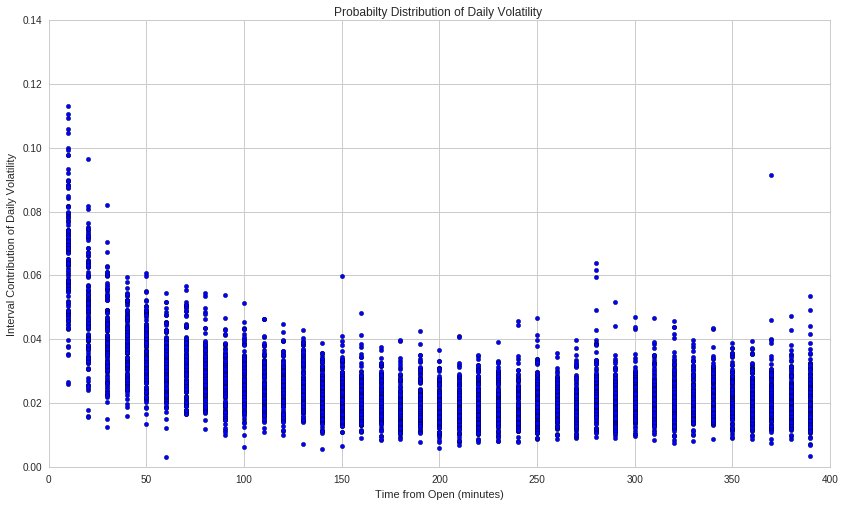

In [17]:
plt.scatter(df.min_of_day, df.interval_pct)
plt.xlim(0,400)
plt.ylim(0,)
plt.xlabel('Time from Open (minutes)')
plt.ylabel('Interval Contribution of Daily Volatility')
plt.title('Probabilty Distribution of Daily Volatility ')

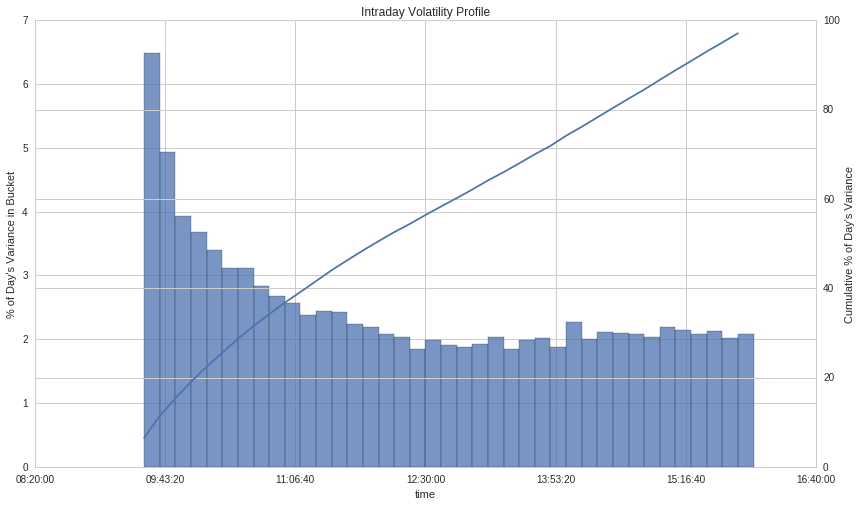

In [18]:
grouped = df.groupby(df.min_of_day)
grouped = df.groupby(df.time) # groupby time
m = grouped.median() # get median
x = m.index
y = m['interval_pct']

fig, ax1 = plt.subplots()
ax1.bar(x, 100*y, 60*10 ,alpha=0.75);# plot interval percent of median daily volatility 
ax2 = ax1.twinx()
ax2.plot(x, (100*y).cumsum()) # plot cummulative distribution of median daily volatility
ax2.set_ylim(0,100);
plt.title('Intraday Volatility Profile')
ax1.set_ylabel('% of Day\'s Variance in Bucket');
ax2.set_ylabel('Cumulative % of Day\'s Variance');
#cut off graph at 4pm

## 买卖价差


在我们的实时交易数据中，可以看到买卖价差和订单属性之间的如下关系:

* 随着**市值**的增加，我们预计利差将下降。大公司往往表现出较低的买卖价差。

* 随着**波动性**增加，我们预计利差将扩大。更大的价格不确定性导致更大的买卖价差。

* 随着**日均美元交易量**增加，我们预计利差将下降。流动性往往与利差成反比，这是因为市场参与者数量更多，报价更新也更频繁。

* 随着**价格**上涨，我们预计利差将下降(与市值相似)，尽管这种关系不那么紧密。

* 随着**一天**时间的进展，我们预计传播将减少。在一个交易日的早期阶段，价格发现会发生。相反，在市场收盘时，完成订单是大多数参与者的首要任务，交易活动由流动性管理主导，而不是价格发现。

交易团队开发了一个符合我们实时数据的对数线性模型，该模型可以预测我们拥有上述属性的证券的价差。

In [5]:
def model_spread(time, vol, mcap = 1.67 * 10 ** 10, adv = 84.5, px = 91.0159):
    time_bins = np.array([0.0, 960.0, 2760.0, 5460.0, 21660.0]) #seconds from market open
    time_coefs = pd.Series([0.0, -0.289, -0.487, -0.685, -0.952])
    
    vol_bins = np.array([0.0, .1, .15, .2, .3, .4])
    vol_coefs = pd.Series([0.0, 0.251, 0.426, 0.542, 0.642, 0.812])
    
    mcap_bins = np.array([0.0, 2.0, 5.0, 10.0, 25.0, 50.0]) * 10 ** 9
    mcap_coefs = pd.Series([0.291, 0.305, 0.0, -0.161, -0.287, -0.499])
    
    adv_bins = np.array([0.0, 50.0, 100.0, 150.0, 250.0, 500.0]) * 10 ** 6
    adv_coefs = pd.Series([0.303, 0.0, -0.054, -0.109, -0.242, -0.454])
    
    px_bins = np.array([0.0, 28.0, 45.0, 62.0, 82.0, 132.0])
    px_coefs = pd.Series([-0.077, -0.187, -0.272, -0.186, 0.0, 0.380])
    
    return np.exp(1.736 +\
                  time_coefs[np.digitize(time, time_bins) - 1] +\
                  vol_coefs[np.digitize(vol, vol_bins) - 1] +\
                  mcap_coefs[np.digitize(mcap, mcap_bins) - 1] +\
                  adv_coefs[np.digitize(adv, adv_bins) - 1] +\
                  px_coefs[np.digitize(px, px_bins) - 1])




### 预测价差以下订单:
* 股票:DPS
* 数量:425股
* 时间:2017年7月19日上午9点41分，开放时间600秒
* 市值:1.67e10
* 波动率:18.8%
* ADV: 929k股;84.5美元
* 平均价格:91.0159

In [6]:
t = 10 * 60
vlty = 0.188
mcap = 1.67 * 10 ** 10
adv = 84.5 *10
price = 91.0159 
print(model_spread(t, vlty, mcap, adv, price), 'bps') 

10.014159084591371 bps


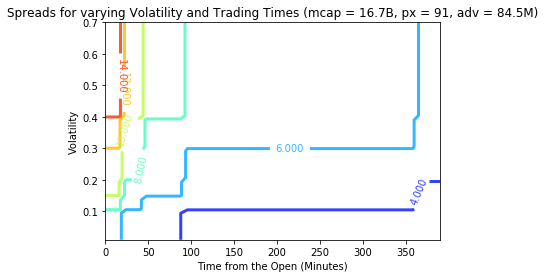

In [8]:
x = np.linspace(0,390*60) # seconds from open shape (50,)
y = np.linspace(.01,.7) # volatility shape(50,)
mcap = 1.67 * 10 ** 10
adv = 84.5
px = 91.0159


vlty_coefs = pd.Series([0.0, 0.251, 0.426, 0.542, 0.642, 0.812])
vlty_bins = np.array([0.0, .1, .15, .2, .3, .4])
time_bins = np.array([0.0, 960.0, 2760.0, 5460.0, 21660.0]) #seconds from market open
time_coefs = pd.Series([0.0, -0.289, -0.487, -0.685, -0.952])
mcap_bins = np.array([0.0, 2.0, 5.0, 10.0, 25.0, 50.0]) * 10 ** 9
mcap_coefs = pd.Series([0.291, 0.305, 0.0, -0.161, -0.287, -0.499])
adv_bins = np.array([0.0, 50.0, 100.0, 150.0, 250.0, 500.0]) * 10 ** 6
adv_coefs = pd.Series([0.303, 0.0, -0.054, -0.109, -0.242, -0.454])
px_bins = np.array([0.0, 28.0, 45.0, 62.0, 82.0, 132.0])
px_coefs = pd.Series([-0.077, -0.187, -0.272, -0.186, 0.0, 0.380])
# shape (1, 50)
time_contrib = np.take(time_coefs, np.digitize(x, time_bins) - 1).values.reshape((1, len(x)))
# shape (50, 1)
vlty_contrib = np.take(vlty_coefs, np.digitize(y, vlty_bins) - 1).values.reshape((len(y), 1))
# scalar
mcap_contrib = mcap_coefs[np.digitize((mcap,), mcap_bins)[0] - 1]
# scalar
adv_contrib = adv_coefs[np.digitize((adv,), adv_bins)[0] - 1]
# scalar
px_contrib = px_coefs[np.digitize((px,), px_bins)[0] - 1]

z_scalar_contrib = 1.736 + mcap_contrib + adv_contrib + px_contrib


Z = np.exp(z_scalar_contrib + time_contrib + vlty_contrib)

cmap=plt.get_cmap('jet')
X, Y = np.meshgrid(x,y)
CS = plt.contour(X/60,Y,Z, linewidths=3, cmap=cmap, alpha=0.8);
plt.clabel(CS)
plt.xlabel('Time from the Open (Minutes)')
plt.ylabel('Volatility')
plt.title('Spreads for varying Volatility and Trading Times (mcap = 16.7B, px = 91, adv = 84.5M)')
plt.show()

## **量化市场影响**

理论市场影响模型试图利用订单属性来估计交易成本。已经发表的市场影响模型有很多。以下是一些例子:

1. Quantopian交易量滑移模型
2. Almgren等人2005年
3. Kissell等人，2004年
4. 摩根大通2010模型


这些模型有一些共同之处，如包含相对订单大小、波动性以及根据观察到的交易计算出的自定义参数。模型中也存在显著的差异，如(1)JPM明确地提出了价差影响，(2)Almgren考虑了每日交易的流通股比例，(3)Q滑差模型没有考虑波动性，(4)Kissel显式参数比例的临时和永久影响，等等。

学术模型有临时和永久影响的概念。**临时影响**指交易的紧迫性或侵略性对交易成本的影响。而**长期影响**估计有关的信息或短期阿尔法交易。

### Almgren等人的模型(2005)

该模型假设初始订单X在交易量时间间隔T内以统一的交易率完成，即交易量单位的交易率为v = X/T，并保持不变，直到交易完成。这些单元中的恒定速率等同于执行期间的VWAP执行。


Almgren等人将这两个术语建模为



$$\text{tcost} = 0.5 \overbrace{\gamma \sigma  \frac{X}{V}\left(\frac{\Theta}{V}\right)^{1/4}}^{\text{permanent}} + \overbrace{\eta \sigma \left| \frac{X}{VT} \right|^{3/5}}^{\text{temporary}} $$


其中$\gamma$和$\eta$是“市场影响的通用系数”，由作者使用大量机构交易样本进行估计;$\sigma$是股票的日波动率;$\Theta$为该股流通在外的总股份;$X$是您希望交易的股票数量(未签名);$T$是交易时间百分比的时间宽度;$V$是股票的平均日成交量(“ADV”)。对$ V $的解释是每日“营业额”的倒数，即公司每日交易价值的一部分。

作为参考，FB有23亿股流通股，其20天的平均日交易量为1880万股，因此其反向成交量约为122股，换句话说，其日交易量不足流通股的4%。



### 潜在的局限性

值得注意的是，Almgren等人(2005)和Kissell, Glantz和Malamut(2004)的论文发表于[__Reg NMS__]https://www.sec.gov/rules/final/34-51808.pdf的采用和分阶段实施之前，在2007年8月“定量崩溃”之前，在2008年第四季度金融危机冲击市场之前，以及在市场微观结构的其他众多发展之前。


In [9]:
def perm_impact(pct_adv, annual_vol_pct = 0.25, inv_turnover = 200):
    gamma = 0.314
    return 10000 * gamma * (annual_vol_pct / 16) * pct_adv * (inv_turnover)**0.25

def temp_impact(pct_adv, minutes, annual_vol_pct = 0.25, minutes_in_day = 60*6.5):
    eta = 0.142
    day_frac = minutes / minutes_in_day
    return 10000 * eta * (annual_vol_pct / 16) * abs(pct_adv/day_frac)**0.6

def tc_bps(pct_adv, minutes, annual_vol_pct = 0.25, inv_turnover = 200, minutes_in_day = 60*6.5):
    perm = perm_impact(pct_adv, annual_vol_pct=annual_vol_pct, inv_turnover=inv_turnover)
    temp = temp_impact(pct_adv, minutes, annual_vol_pct=annual_vol_pct, minutes_in_day=minutes_in_day)
    return 0.5 * perm + temp


因此，如果我们交易一只股票10%的ADV，日波动率为1.57%，并且我们计划在半天内完成交易，那么我们预计TC的收益率为8个基点(在这种情况下，这是Almgren对临时影响成本的估计)。从论文来看，这是不同交易速度下的一小部分产出:

  Variable      |      IBM
  ------------- | -------------
  Inverse turnover ($\Theta/V$) | 263
  Daily vol ($\sigma$)  | 1.57%
  Trade % ADV (X/V) | 10%
  
  Item | Fast | Medium | Slow
  -----|------|--------|-------
  Permanent Impact (bps) | 20 | 20 | 20
  Trade duration (day fraction %) | 10% | 20% | 50%
  Temporary Impact (bps) | 22 | 15 | 8
  Total Impact (bps) | 32 | 25 | 18
  

In [10]:
print( 'Cost to trade Fast (First 40 mins):', round(tc_bps(pct_adv=0.1, annual_vol_pct=16*0.0157, inv_turnover=263, minutes=0.1*60*6.5),2), 'bps')
print( 'Cost to trade Medium (First 90 mins):', round(tc_bps(pct_adv=0.1, annual_vol_pct=16*0.0157, inv_turnover=263, minutes=0.2*60*6.5),2), 'bps') 
print( 'Cost to trade Slow by Noon:', round(tc_bps(pct_adv=0.1, annual_vol_pct=16*0.0157, inv_turnover=263, minutes=0.5*60*6.5),2), 'bps')


Cost to trade Fast (First 40 mins): 32.22 bps
Cost to trade Medium (First 90 mins): 24.63 bps
Cost to trade Slow by Noon: 18.41 bps


交易0.50%的ADV的股票，日波动率为1.57%，我们计划在30分钟内完成。

In [11]:
print(round(tc_bps(pct_adv=0.005, minutes=30, annual_vol_pct=16*0.0157),2)) 

4.79


假设我们想要交易价值200万美元的Facebook，我们将把交易发送到一个执行算法(例如，VWAP)，并在15分钟内将其切片。

In [12]:
trade_notional = 2000000 # 2M notional
stock_price = 110.89 # dollars per share
shares_to_trade = trade_notional/stock_price
stock_adv_shares = 30e6 # 30 M
stock_shares_outstanding = 275e9/110.89

expected_tc = tc_bps(shares_to_trade/stock_adv_shares, minutes=15, annual_vol_pct=0.22)
print ("Expected tc in bps: %0.2f" % expected_tc)
print ("Expected tc in $ per share: %0.2f" % (expected_tc*stock_price / 10000))

Expected tc in bps: 1.66
Expected tc in $ per share: 0.02


为了激发一些直觉，总期望成本随我们想要在30分钟内交易多少%ADV的函数而变化。

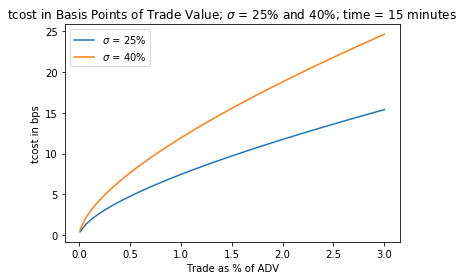

In [13]:
x = np.linspace(0.0001,0.03)
plt.plot(x*100,tc_bps(x,30,0.25), label="$\sigma$ = 25%");
plt.plot(x*100,tc_bps(x,30,0.40), label="$\sigma$ = 40%");
plt.ylabel('tcost in bps')
plt.xlabel('Trade as % of ADV')
plt.title('tcost in Basis Points of Trade Value; $\sigma$ = 25% and 40%; time = 15 minutes');
plt.legend();

让我们看看tcost作为交易时间和% ADV的函数。

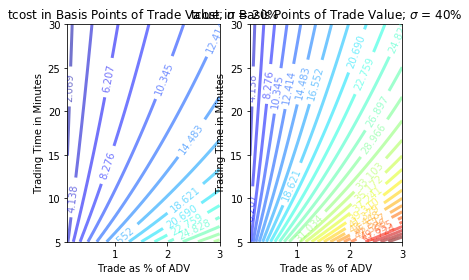

In [14]:
x = np.linspace(0.001,0.03)
y = np.linspace(5,30)
X, Y = np.meshgrid(x,y)
Z = tc_bps(X,Y,0.20)
levels = np.linspace(0.0, 60, 30)
cmap=plt.get_cmap('Reds')
cmap=plt.get_cmap('hot')
cmap=plt.get_cmap('jet')

plt.subplot(1,2,1);
CS = plt.contour(X*100, Y, Z, levels, linewidths=3, cmap=cmap, alpha=0.55);
plt.clabel(CS);
plt.ylabel('Trading Time in Minutes');
plt.xlabel('Trade as % of ADV');
plt.title('tcost in Basis Points of Trade Value; $\sigma$ = 20%');

plt.subplot(1,2,2);
Z = tc_bps(X,Y,0.40)
CS = plt.contour(X*100, Y, Z, levels, linewidths=3, cmap=cmap, alpha=0.55);
plt.clabel(CS);
plt.ylabel('Trading Time in Minutes');
plt.xlabel('Trade as % of ADV');
plt.title('tcost in Basis Points of Trade Value; $\sigma$ = 40%');

或者，我们可能想要得到一些直觉，如果我们想要限制我们的成本，交易时间如何变化与%的ADV。

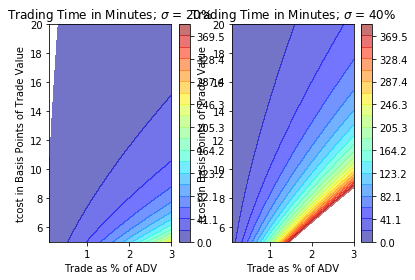

In [15]:
x = np.linspace(0.001,0.03) # % ADV
y = np.linspace(1,60*6.5)   # time to trade
X, Y = np.meshgrid(x, y)

levels = np.linspace(0.0, 390, 20)
cmap=plt.get_cmap('Reds')
cmap=plt.get_cmap('hot')
cmap=plt.get_cmap('jet')

plt.subplot(1,2,1);

Z = tc_bps(X,Y,0.20)
plt.contourf(X*100, Z, Y, levels, cmap=cmap, alpha=0.55);
plt.title('Trading Time in Minutes; $\sigma$ = 20%');
plt.xlabel('Trade as % of ADV');
plt.ylabel('tcost in Basis Points of Trade Value');
plt.ylim(5,20)
plt.colorbar();

plt.subplot(1,2,2);
Z = tc_bps(X,Y,0.40)
plt.contourf(X*100, Z, Y, levels, cmap=cmap, alpha=0.55);
plt.title('Trading Time in Minutes; $\sigma$ = 40%');
plt.xlabel('Trade as % of ADV');
plt.ylabel('tcost in Basis Points of Trade Value');
plt.ylim(5,20);
plt.colorbar();



### 分类:永久和临时

对于一个典型的股票，让我们看看如何将tcost分解为永久和临时。

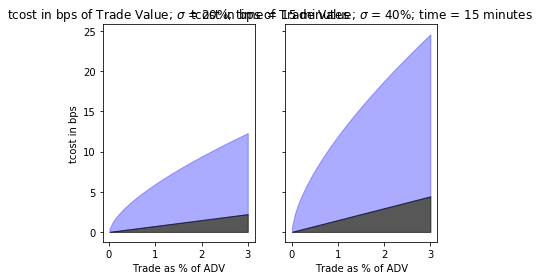

In [16]:
minutes = 30

x = np.linspace(0.0001,0.03)

f, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True)
f.subplots_adjust(hspace=0.15)
    
p = 0.5*perm_impact(x,0.20)
t = tc_bps(x,minutes,0.20)
ax1.fill_between(x*100, p, t, color='b', alpha=0.33);
ax1.fill_between(x*100, 0, p, color='k', alpha=0.66);
ax1.set_ylabel('tcost in bps')
ax1.set_xlabel('Trade as % of ADV')
ax1.set_title('tcost in bps of Trade Value; $\sigma$ = 20%; time = 15 minutes');

p = 0.5*perm_impact(x, 0.40)
t = tc_bps(x,minutes, 0.40)
ax2.fill_between(x*100, p, t, color='b', alpha=0.33);
ax2.fill_between(x*100, 0, p, color='k', alpha=0.66);

plt.xlabel('Trade as % of ADV')
plt.title('tcost in bps of Trade Value; $\sigma$ = 40%; time = 15 minutes');

### Kissell等人的模型(2004)

这个模型假设，如果所有的股票$Q$都被投放到市场上，投资者会产生理论上的冲击I^*$。

$$ MI_{bp} = b_1 I^* POV^{a_4} + (1-b_1)I^*$$


$$ I^*  = a_1 (\frac{Q}{ADV})^{a_2} \sigma^{a_3}$$

$$POV = \frac{Q}{Q+V}$$

* $I^*$是瞬时冲击
* $POV$是交易量的百分比
* $V$是交易时段的预期成交量
$ b_1$是临时影响参数
* $ADV$是30天的平均日成交量
* $Q$是订单大小


  Parameter      |      Fitted Values
  ------------- | -------------
  $b_1$ | 0.80
  $a_1$  | 750
  $a_2$  | 0.50
  $a_3$  | 0.75
  $a_4$  | 0.50

In [17]:
def kissell(adv, annual_vol, interval_vol, order_size):
    b1, a1, a2, a3, a4 = 0.9, 750., 0.2, 0.9, 0.5
    i_star = a1 * ((order_size/adv)**a2) * annual_vol**a3
    PoV = order_size/(order_size + adv)
    return b1 * i_star * PoV**a4 + (1 - b1) * i_star

In [18]:
print( kissell(adv = 5*10**6, annual_vol = 0.2, interval_vol = adv * 0.06, order_size = 0.01 * adv ), 'bps')

0.781932862914937 bps


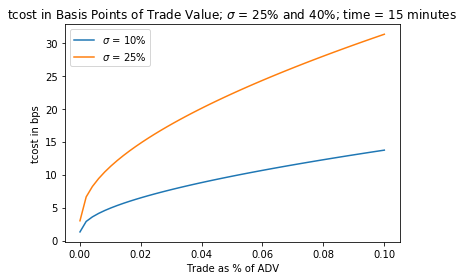

In [19]:
x = np.linspace(0.0001,0.1)
plt.plot(x,kissell(5*10**6,0.1, 2000*10**3, x*2000*10**3), label="$\sigma$ = 10%");
plt.plot(x,kissell(5*10**6,0.25, 2000*10**3, x*2000*10**3), label="$\sigma$ = 25%");
#plt.plot(x,kissell(5*10**6,0.40, 2000*10**3, x*2000*10**3), label="$\sigma$ = 40%");
plt.ylabel('tcost in bps')
plt.xlabel('Trade as % of ADV')
plt.title('tcost in Basis Points of Trade Value; $\sigma$ = 25% and 40%; time = 15 minutes');
plt.legend();

## 摩根大通的市场影响模型


$$MI(bps) = I \times \omega \times \frac{2 \times PoV}{1 + PoV} + (1-\omega) \times I + S_c$$
Where

$$I = \alpha \times PoV^\beta \times Volatility^\gamma$$

* $\omega$是临时影响(流动资金成本)的分数
* $\alpha$是一个缩放参数
* $PoV$是相对订单大小，作为平均日交易量的一部分
* $S_c$是价差(买卖价差的基点)


对于美国股市，截至2016年6月的拟合参数为

  Parameter | Fitted Value
  ------|-----
  b ($\omega$) | 0.931
  a1 ($\alpha$)| 168.5
  a2 ($\beta$) | 0.1064
  a3 ($\gamma$) | 0.9233


In [20]:
from __future__ import division

def jpm_mi(size_shrs, adv, day_frac=1.0, spd=5,
           spd_frac=0.5, ann_vol=0.25, omega=0.92,
           alpha=350, beta=0.370, gamma=1.05):

    PoV = (size_shrs/(adv*day_frac))
    I = alpha*(PoV**beta)*(ann_vol**gamma)
    MI = I*omega*(2*PoV)/(1+PoV) + (1-omega)*I + spd*spd_frac
    return MI

def jpm_mi_pct(pct_adv, **kwargs):
    return jpm_mi(pct_adv, 1.0, **kwargs)


我们假设顺序如下:
* 购买100,000 XYZ，交易金额为交易量的10%
* XYZ的ADV = 1,000,000股
* XYZ年化波动率= 25%
* XYZ的平均利差= 5个基点

In [21]:
spy_adv = 85603411.55
print (round(jpm_mi(size_shrs = 10000, adv = 1e6),2), 'bps') # 1% pct ADV order
print (round(jpm_mi(size_shrs = 0.05*spy_adv, adv = spy_adv, spd = 5, day_frac = 1.0),2), 'bps') # 5% pct ADV of SPY order

3.96 bps
7.02 bps


##  Quantopian股份滑动

[Q `VolumeShareSlippage`模型](https://www.quantopian.com/help#ide-slippage)表达如下式

$$\text{tcost} = 0.1 \left| \frac{X}{VT} \right|^2 $$

其中$X$是你希望交易的股份数目;$T$是条的时间宽度，单位是一天的百分比;$V$是股票的ADV。

有关Quantopian滑移模型的更多信息请参见:https://www.quantopian.com/help#ide-slippage

In [22]:
def tc_Q_vss_bps(pct_adv, minutes=1.0, minutes_in_day=60*6.5):
    day_frac = minutes / minutes_in_day
    tc_pct = 0.1 * abs(pct_adv/day_frac)**2
    return tc_pct*10000

为了重现给定的Q例子，我们在一个bar上进行交易

In [23]:
print (tc_Q_vss_bps(pct_adv=0.1/390, minutes=1))
print (tc_Q_vss_bps(pct_adv=0.25/390, minutes=1))

10.000000000000002
62.5


由于该模型是凸的，它对大型交易给出了很高的估计。

In [24]:
print (tc_Q_vss_bps(pct_adv=0.1, minutes=0.1*60*6.5))
print( tc_Q_vss_bps(pct_adv=0.1, minutes=0.2*60*6.5))
print (tc_Q_vss_bps(pct_adv=0.1, minutes=0.5*60*6.5))

1000.0
250.0
40.00000000000001


尽管是小规模的交易，结果是相似的。

In [26]:
print (tc_bps(pct_adv=0.005, minutes=30, annual_vol_pct=0.2))
print (tc_Q_vss_bps(pct_adv=0.005, minutes=30))

3.81208329371434
4.2250000000000005


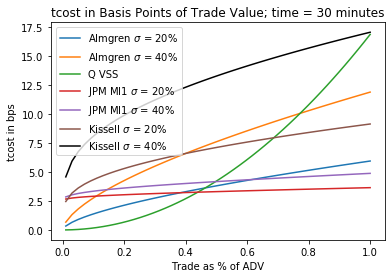

In [27]:
x = np.linspace(0.0001, 0.01)
plt.plot(x*100,tc_bps(x, 30, 0.20), label="Almgren $\sigma$ = 20%");
plt.plot(x*100,tc_bps(x, 30, 0.40), label="Almgren $\sigma$ = 40%");
plt.plot(x*100,tc_Q_vss_bps(x, minutes=30),label="Q VSS");
plt.plot(x*100,jpm_mi_pct(x, ann_vol=0.2), label="JPM MI1 $\sigma$ = 20%");
plt.plot(x*100,jpm_mi_pct(x, ann_vol=0.4), label="JPM MI1 $\sigma$ = 40%");
plt.plot(x*100,kissell(5*10**6,0.20, 2000*10**3, x*2000*10**3), label="Kissell $\sigma$ = 20%");
plt.plot(x*100,kissell(5*10**6,0.40, 2000*10**3, x*2000*10**3), label="Kissell $\sigma$ = 40%", color='black');

plt.ylabel('tcost in bps')
plt.xlabel('Trade as % of ADV')
plt.title('tcost in Basis Points of Trade Value; time = 30 minutes');
plt.legend();

## 结论

### 以下订单将带来更高的市场影响:
* 较高的相对订单大小
* 交易illquid名字
* 每日成交额较低的交易名称(以流通股计算)
* 缩短交易期限
* 高波动性名称
* 更紧急或更高的POV
* 短期alpha值
* 当天早些时候交易
* 买卖价差较大的股票
* 交易较低的ADV名称或在市场交易量下降的日子


## 参考:

* Almgren, R., Thum, C., Hauptmann, E., & Li, H. (2005). Direct estimation of equity market impact. Risk, 18(7), 5862.

* Bennett, C. and Gil, M.A. (2012, Februrary)  Measuring Historic Volatility, Santander Equity Derivatives Europe Retreived from: (http://www.todaysgroep.nl/media/236846/measuring_historic_volatility.pdf)

* Garman, M. B., & Klass, M. J. (1980). On the estimation of security price volatilities from historical data. Journal of business, 67-78.

* Kissell, R., Glantz, M., & Malamut, R. (2004). A practical framework for estimating transaction costs and developing optimal trading strategies to achieve best execution. Finance Research Letters, 1(1), 35-46.

* Quantopian Slippage Model see : https://www.quantopian.com/help#ide-slippage
